M. Amintoosi

https://www.mathworks.com/help/optim/ug/deblur-problem-based.html

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
import requests
from io import BytesIO

(100, 208)

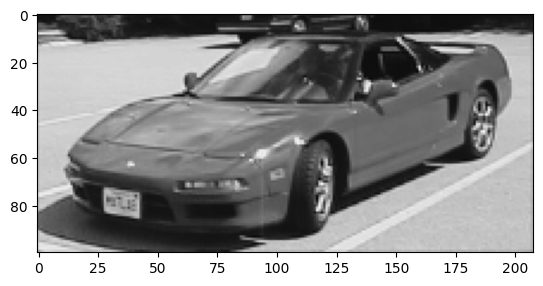

In [11]:
img_url = "https://raw.githubusercontent.com/fum-cs/dl/master/code/images/optdeblur_01.jpg"
response = requests.get(img_url) # this gets the image data from the URL
img = io.imread(BytesIO(response.content))

# img = io.imread('images/optdeblur_01.jpg')
P = rgb2gray(img)
# P = resize(P, (75,150))
P = resize(P, (100,208))
plt.imshow(P, cmap='gray') 
P.shape

In [12]:
m, n = P.shape
mn = m * n

# Add Motion
# Simulate the effect of vertical motion blurring by averaging each pixel with the 5 pixels above and below. Construct a sparse matrix D to blur with a single matrix multiply.
# mn = 5
blur = 5
mindex = np.arange(mn) 
nindex = np.arange(mn) 
for i in range(blur):
    mindex = np.concatenate((mindex, np.arange(i+1 , mn ), np.arange(0, mn - i-1)))
    nindex = np.concatenate((nindex, np.arange(0, mn - i-1), np.arange(i+1 , mn )))
D = csr_matrix((np.ones_like(mindex)*1/(2*blur+1), (mindex , nindex )), shape=(mn, mn))
# mindex+1, nindex+1, D.toarray(), #D[:6].toarray()
D.shape

(20800, 20800)

In [13]:
D[:3,:10].toarray()

array([[0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.        , 0.        , 0.        , 0.        ],
       [0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.09090909, 0.        , 0.        , 0.        ],
       [0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.09090909, 0.09090909, 0.        , 0.        ]])

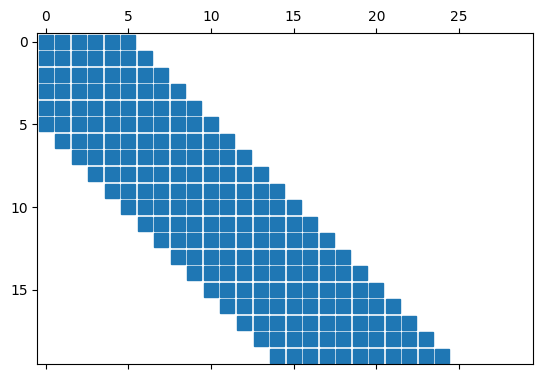

In [14]:
plt.spy(D[0:20, 0:30])
plt.show()

In [15]:
P.flatten()[:5], P[0,:5], P[:5,0]

(array([0.09701371, 0.09705054, 0.09697521, 0.09925708, 0.09626223]),
 array([0.09701371, 0.09705054, 0.09697521, 0.09925708, 0.09626223]),
 array([0.09701371, 0.10293342, 0.10461351, 0.14205522, 0.3358845 ]))

## Motion blur in x-axis direction

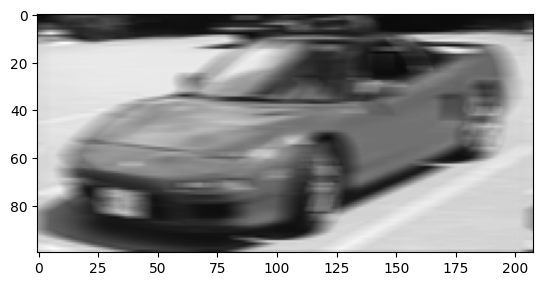

In [16]:
G = D@P.flatten()
plt.imshow(G.reshape(m,n),cmap='gray')

## Motion blur in y-axis direction

In [17]:
# G = D@P.T.flatten()
# plt.imshow(G.reshape(n,m).T,cmap='gray')

In [18]:
D.shape, P.flatten().shape, G.shape

((20800, 20800), (20800,), (20800,))

The *minimize* function failed to find a feasible or optimal solution for the problem

SLSQPm needs 130GB of RAM!

In [19]:
# import numpy as np
# from scipy.optimize import minimize
# from scipy.optimize import lsq_linear

# x = np.zeros(mn)
# bounds = [(0, 1)] * mn

# def objective(x):
#     expr = D.dot(x) - G
#     return np.dot(expr,expr)
#     # expr = D@x - G
#     # return expr.T@expr

# # sol = minimize(objective, x, bounds=bounds)
# # sol = minimize(objective, x, bounds=bounds, method='Nelder-Mead') #L-BFGS-B
# sol = lsq_linear(D, G, bounds=(0,1))

# sol.x

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.lsq_linear.html

In [20]:
%%time
from scipy.optimize import lsq_linear

sol = lsq_linear(D, G, bounds=(0,1))
xpic = sol.x.reshape(m,n)

CPU times: total: 17.2 s
Wall time: 21.8 s


In [21]:
# P[0,:10], xpic[0,:10]

In [22]:
P[30,:5], xpic[30,:5]

(array([0.73120553, 0.79376967, 0.79121882, 0.78839188, 0.78733728]),
 array([0.73222747, 0.79468509, 0.79050181, 0.7884607 , 0.78715651]))

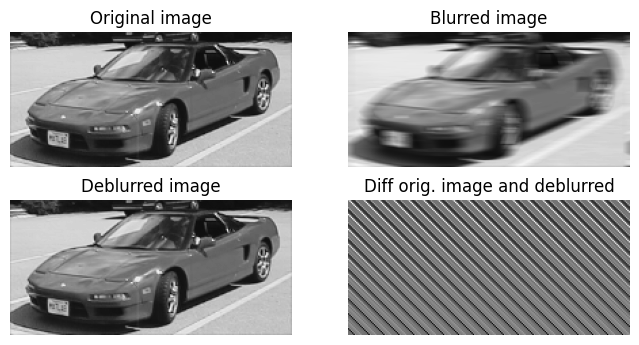

In [23]:

fig = plt.figure(figsize=(8,4))
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(221) 
ax2 = fig.add_subplot(222)   
ax3 = fig.add_subplot(223)   
ax4 = fig.add_subplot(224)   
ax1.imshow(P, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Original image')

ax2.imshow(G.reshape(m,n))
ax2.set_axis_off()
ax2.set_title('Blurred image')

ax3.imshow(xpic, cmap='gray')
ax3.set_axis_off()
ax3.set_title('Deblurred image')

ax4.imshow(P-xpic)#, vmin=0, vmax=1)
ax4.set_axis_off()
ax4.set_title('Diff orig. image and deblurred')

plt.show()

In [24]:
np.sum(P-xpic)

0.0009316929684256153

We get error in inversing of D

In [32]:
np.linalg.inv(D)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional